In [ ]:
import sys
import os

src_path = os.path.expanduser('../')

if src_path not in sys.path:
    sys.path.append(src_path)

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2 as cv
from src.draw import Canvas
from src.optimizers import SimulatedAnnealing, mse
from ipywidgets import interact, IntSlider, Play, VBox, jslink

In [ ]:
def discrete_normal(mu, sigma):
    while True:
        x = int(np.round(np.random.normal(mu, sigma)))
        if x != 0:
            return x

In [ ]:
ref_image = cv.imread('../src/img/example_001.png')

In [ ]:
n_iterations = 500

In [ ]:
canvas = Canvas(cache_size=n_iterations)

In [ ]:
canvas._history_index

1

In [ ]:
canvas.draw.circle(center=(500,300), radius=5)

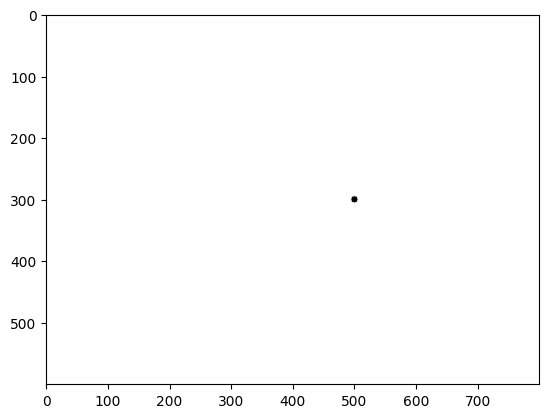

In [ ]:
plt.imshow(canvas.canvas)

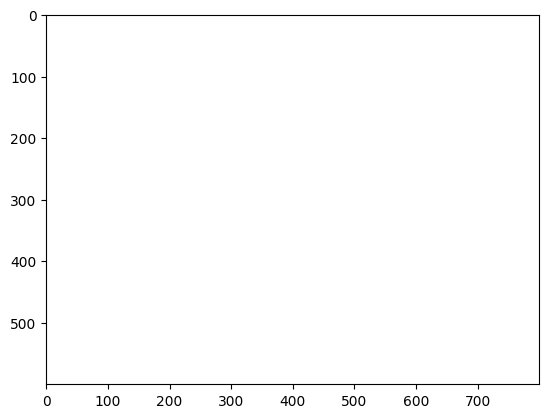

In [14]:
# canvas.revert()
plt.imshow(canvas.previous_state)

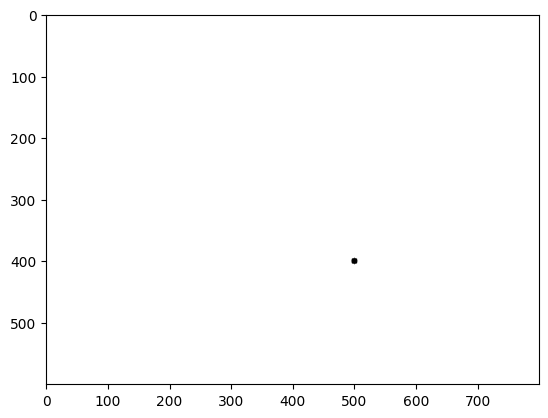

In [11]:
plt.imshow(canvas._state_history[1])

In [8]:
sa_optimizer = SimulatedAnnealing(
    max_iterations=n_iterations,
    loss=mse,
    sampler=lambda: discrete_normal(0, 25)
)

In [9]:
y_hat = sa_optimizer.optimize(
    canvas=canvas,
    reference=ref_image)

/Users/tadzio/git/procedural-painting/notebooks/../src/optimizers.py:54: RuntimeWarning: overflow encountered in exp
  acceptance_criterion = np.exp((previous_loss - new_loss) / self.current_temp)


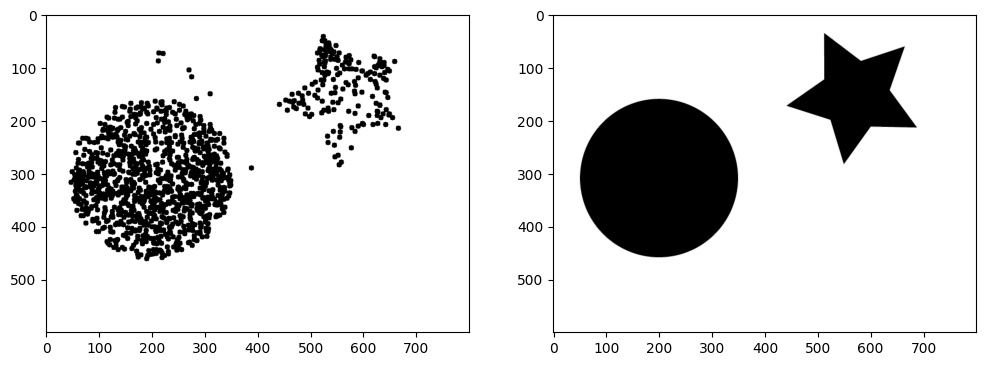

In [10]:
f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(canvas.canvas)
ax[1].imshow(ref_image)

In [14]:
def show_state(canvas: Canvas, index: int) -> None:
    """Display a specific state of the canvas."""
    if index < 0 or index >= canvas._history_index:
        print("Invalid index.")
        return
    
    plt.imshow(cv.cvtColor(canvas._state_history[index], cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"State {index}")
    plt.show()


# Creating a function to setup interactive controls in Jupyter
def visualize_canvas_history(canvas: Canvas) -> None:
    """Visualize the canvas history with slider and play button."""
    slider = IntSlider(value=0, min=0, max=canvas._history_index - 1, step=1, description='State')
    play = Play(interval=200, value=0, min=0, max=canvas._history_index - 1, step=1, description="Play")

    # Link play and slider widgets
    jslink((play, 'value'), (slider, 'value'))

    interact(lambda index: show_state(canvas, index), index=slider)
    display(VBox([play, slider]))

In [ ]:
canvas

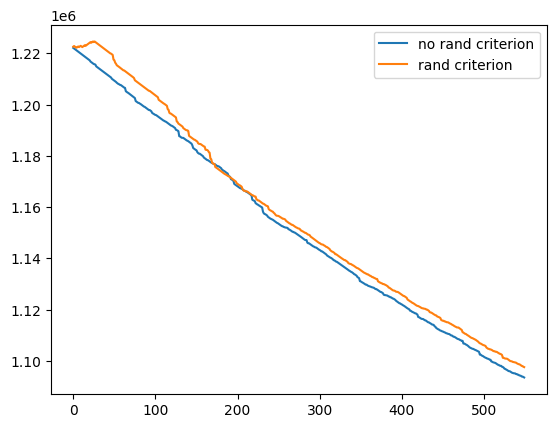

In [13]:
plt.plot(np.array(sa_optimizer._errors[:550]), label='no rand criterion')
plt.plot(np.array(sa_optimizer_rcriterion._errors[:550]), label='rand criterion')
plt.legend()

In [24]:
sa_optimizer_rcriterion._errors.shape

AttributeError: 'list' object has no attribute 'shape'

In [12]:
np.array(sa_optimizer_rcriterion._errors).shape

(628,)